# Tutorial - Graph Network Simulator Usage

This notebook demonstrates how to quickly:

1. Do a simulation using the implemented Graph Network Simulator + a pre-trained GNN model
2. Compare the results of a GNS simulation with a "Ground Truth" simulation.

In [1]:
import os
import jax
import sys
import numpy as np
import jax.numpy as jnp
from pathlib import Path

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt

sys.path.append('../..')
from gns.simulator import SMGNS
from gns.utils import get_dx_eq, get_x_eq
from gns.tests import plot_trajectory_comparison
from sheet_model.utils import plot_XVE

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Running a Simulation

First, you need to select a pre-trained model by providing the path to the folder where the model weights and other training files are stored. 

We have made a few pre-trained models available for download (instructions in the repository README file), we will be using one of them.

In [2]:
model_folder = Path('../../models/final/dt1e-1/0')

To initialize the simulator it is only mandatory to set the boundary conditions. The simulation box length and verbosity level have default values which can be changed. 

In [3]:
boundary = 'periodic' # 'periodic' or 'reflecting'
                      # GNN model does not need to have been trained for these boundary conditions!

L = 1. # will be set to 1 by default
       # does not have to match the length used for the training simulations.

verbose = True # print the chosen model/boundary + training data information

sim = SMGNS(model_folder, 
            boundary,
            verbose=verbose)

Simulator Info
   GNN model: ../../models/final/dt1e-1/0
   boundary: periodic
   L: 1
   dt_train: 0.1
   Training Dataset
      L: 1.0
      augment_t: True
      augment_x: True
      boundary: periodic
      data_folder: data/dataset/train/10/periodic/
      dt_simulator: 0.01
      dt_undersample: 10
      mode: crossings
      n_neighbors: 1
      n_sheets: 10
      save_folder: data/processed_temp/train/dt1e-1
      var_target: dvdt
      w_size: 1


The simulator can now be used for any system size. 

One needs first to specify the initial conditions (sheet position, velocity, and equilibrium positions).

**IMPORTANT**: The GNS uses the finite difference velocities and not the instantaneous velocities of the sheets! (which are used for the Sheet Model)

In [4]:
n_sheets = 10 # number of sheets

x_eq = get_x_eq(n_sheets, sim.L)
dx_eq = get_dx_eq(n_sheets, sim.L)

np.random.seed(42) # for reproducibility

x_0 = x_eq.copy() # sheets start in the equilibrium positions
v_max = 2 * dx_eq # max initial velocity [L w_p]
v_0 = np.random.uniform(-v_max,v_max, n_sheets)

And then some extra parameters which have similar meaning to those used for the Synchronous Sheet Model Algorithm interface.

In [5]:
t_max = 10 # simulation time [1/w_p]

n_guards = 0 if sim.boundary == 'periodic' else 5 # number of guard sheets to use 
                                                  # we usually set it to the number of message passing steps

track_sheets = False # if True trajectories are returned as if sheets crossed each other. 
                     # otherwise, trajectories will represent crossings as collisions.

We can then run a simulation. The first iteration will take a longer time because the code is being compiled by XLA. The next ones should be significantly fast. Further calls to the pred_rollout() function should not re-trigger re-compilation unless there are changes in the:

- number of sheets or the number of guards
- model used
- boundary
- track_sheets

In [6]:
X, V, X_eq, E = sim.pred_rollout(x_0=x_0,
                                 v_0=v_0,
                                 x_eq_0=x_eq,
                                 t_max=t_max,
                                 n_guards=n_guards,
                                 track_sheets=track_sheets,
                                 verbose=True, # print progress bar
                                 np_=np # array format returned, use np or jnp
                                 )

  0%|          | 0/100 [00:00<?, ?it/s]

The outputs correspond to time-series of the sheets positions, velocities, equilibrium positions, and total energy of the system

In [7]:
print(X.shape, V.shape, X_eq.shape, E.shape)

(101, 10) (101, 10) (101, 10) (101,)


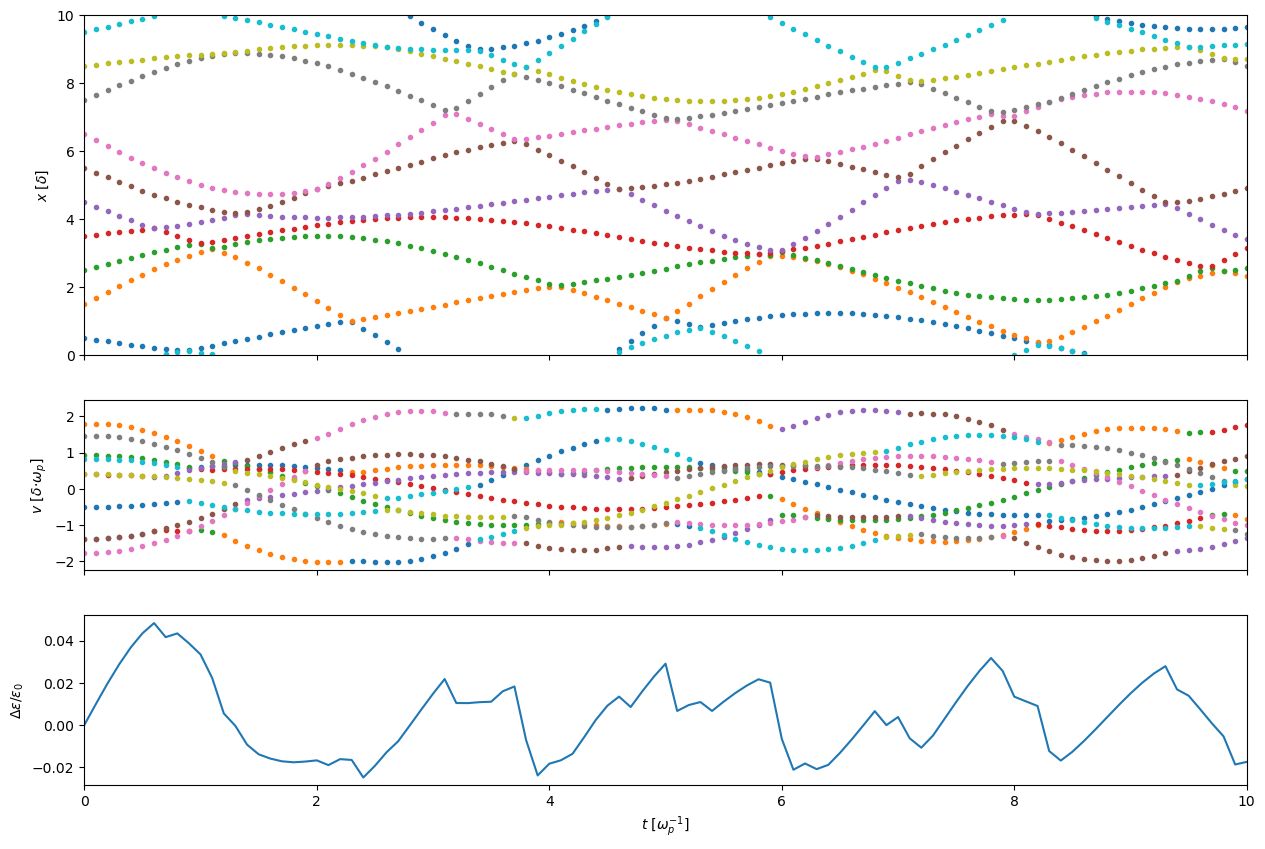

In [8]:
plot_XVE(X=X,V=V,E=E,T=sim.dt_train)

Things to try out:

- What happens when setting track_sheets = False
- Check other optional arguments in pred_rollout()

## Comparing with a "Ground Truth" Simulation

We will now show how to compare a GNS simulation with one produced by the Sheet Model (which you can consider as the Ground Truth).

For details regarding the Sheet Model algorithm interface refer to the [companion notebook](Sheet_Model_Async&Sync.ipynb). For simplicity, we will be using the synchronous version.

In [9]:
from sheet_model.synchronous import SyncSheetModel

dt_sm = 1e-2

sim_sm = SyncSheetModel(L=L,
                        boundary=boundary,
                        n_sheets=n_sheets,
                        dt=dt_sm,
                        n_guards=2,
                        n_it_crossings=2,
                        track_sheets=track_sheets)

In [10]:
X_sm, V_sm, X_eq_sm, E_sm = sim_sm.run_simulation(x_0=x_0,
                                                  v_0=v_0,
                                                  t_max=t_max)

  0%|          | 0/1000 [00:00<?, ?it/s]

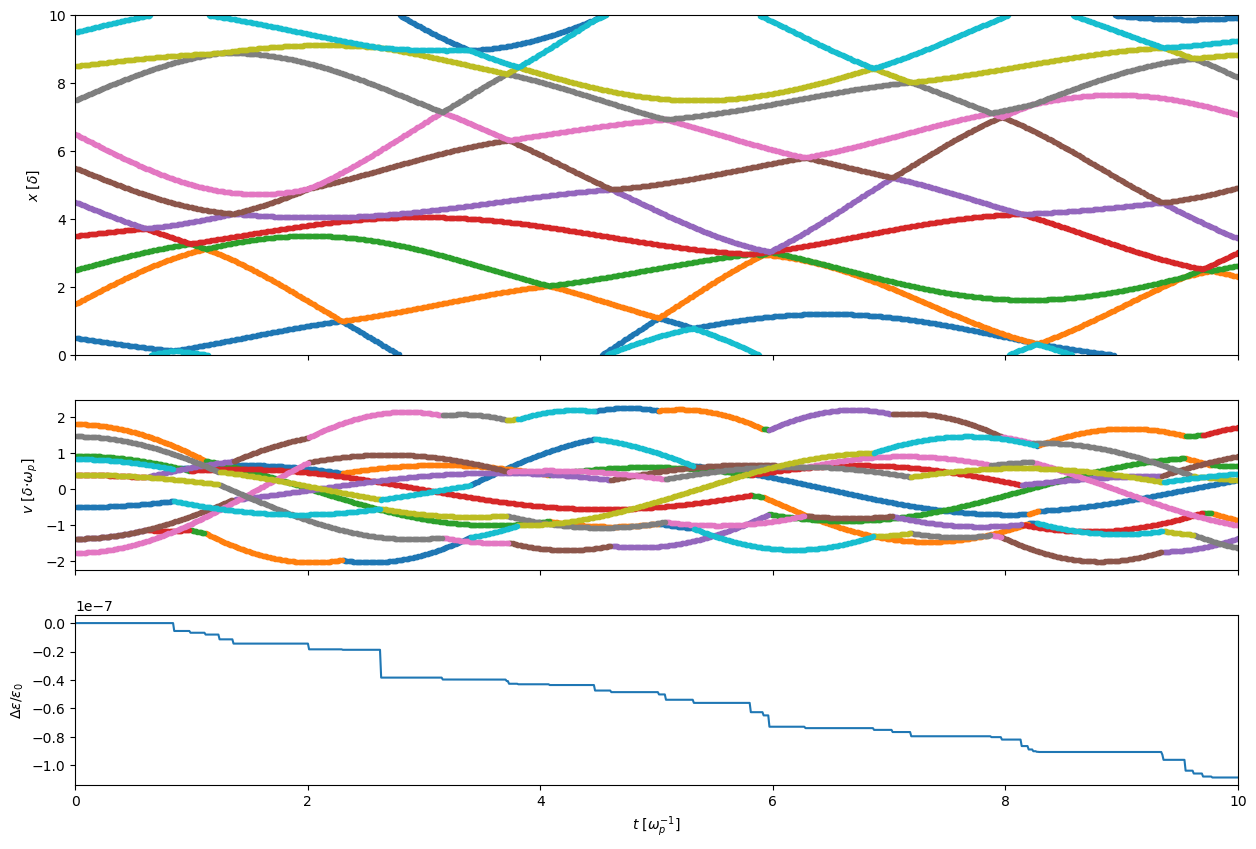

In [11]:
plot_XVE(X_sm, V_sm, E_sm, T=dt_sm)

Now, since the Sheet Model uses the instantaneous velocities, we can not use the same input to the GNS if we want to compare the predicted trajectories, as the latter consideres the finite difference velocities as input.

We have to do a small trick to be able to compute the right initial conditions for the GNS.

We can either:

- Compute the finite difference velocity at $t=0$ by using the Sheet Model to go back one time-step, i.e. until $t=-\Delta t_{GNS}$, so that we have the correct position.

- Start the GNS simulation at $t = \Delta t_{GNS}$, since we can use the sheet model position at $t=0$ and $t= \Delta t_{GNS}$ to compute the finite differnce velocity.

We have routines that allow you to do either.

### Starting at $t = 0$

**Important**: Only implemented for GNS trained for mode = crossings (which is the default, do not use when considering collisions!)

In [12]:
from gns.preprocess import init_GNS_as_SM

x_0_gns, v_0_gns, x_eq_0_gns, _ = init_GNS_as_SM(x_0, 
                                                 v_0,
                                                 x_eq,
                                                 gns=sim)

Note that the initial postions used for the GNS is equal to the positions of the Sheet Model data at $t=0$

In [13]:
print('GNS Initial Initial Positions')
print(x_0_gns)
print('Sheet Model Positions @ t = sim.dt_train')
print(X_sm[0])
print('Equal?', np.array_equal(x_0_gns, X_sm[0]))

GNS Initial Initial Positions
[0.05       0.15000001 0.25       0.34999999 0.45000002 0.55000001
 0.65000004 0.75       0.85000002 0.94999999]
Sheet Model Positions @ t = sim.dt_train
[0.05       0.15000001 0.25       0.34999999 0.45000002 0.55000001
 0.65000004 0.75       0.85000002 0.94999999]
Equal? True


But the velocities slightly differ, since the GNS uses the finitie difference velocities, while the Sheet Model uses the instantaneous value.

In [14]:
print('GNS Initial Initial Velocities')
print(v_0_gns)
print('Sheet Model Velocities @ t = sim.dt_train')
print(V_sm[0])
print('Equal?', np.array_equal(v_0_gns, V_sm[0]))

GNS Initial Initial Velocities
[-0.05010035  0.17998546  0.09264305  0.03939778 -0.13736337 -0.13737321
 -0.17647207  0.14622629  0.04037857  0.08309066]
Sheet Model Velocities @ t = sim.dt_train
[-0.05018395  0.18028572  0.09279758  0.03946339 -0.13759254 -0.13760219
 -0.17676656  0.14647046  0.040446    0.08322903]
Equal? False


We can now run the GNS simulation and compare with the trajectories obtained with the Sheet Model

In [15]:
X_gns, V_gns, _, E_gns = sim.pred_rollout(x_0=x_0_gns,
                                          v_0=v_0_gns,
                                          x_eq_0=x_eq_0_gns,
                                          t_max=t_max,
                                          n_guards=n_guards,
                                          track_sheets=track_sheets)

  0%|          | 0/100 [00:00<?, ?it/s]

Rollout MAE: 0.0003 [L], 0.0029 [dx_eq]
Rollout EMD: 0.0003 [L], 0.0029 [dx_eq]


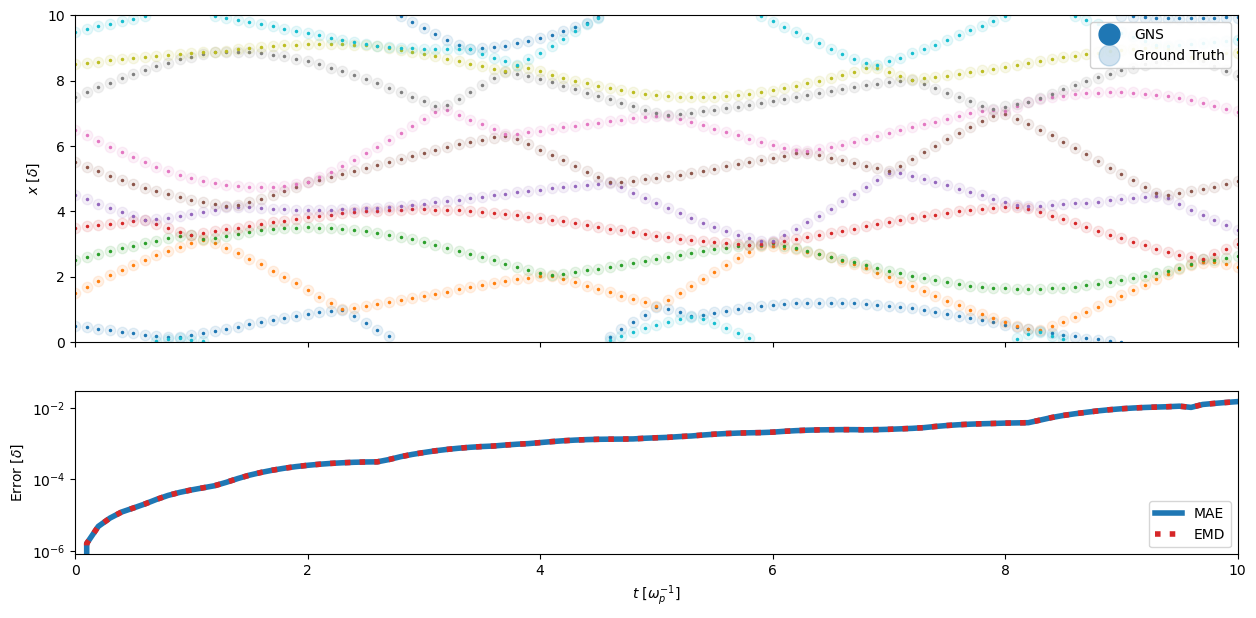

In [16]:
dt_undersample = int(sim.dt_train // dt_sm) # undersample factor needed to apply to Sheet Model data 
                                            # so it matches the GNS time-step
    
plot_trajectory_comparison(X_gns, 
                           X_sm[::dt_undersample], 
                           boundary, sim.dt_train, normalize_dx_eq=True) 

### Starting at $t = \Delta t_{GNS}$

In [17]:
from gns.preprocess import init_XV_crossings # if the GNS was trained with mode=collisions, use init_XV_collisions

x_0_gns, v_0_gns, x_eq_0_gns = init_XV_crossings(X_sm[::dt_undersample],
                                                 V_sm[::dt_undersample],
                                                 X_eq_sm[::dt_undersample],
                                                 dt=sim.dt_train, 
                                                 boundary=sim.boundary,
                                                 L=L)

Note that the initial postions used for the GNS are equal to the positions of the Sheet Model data at $t = \Delta t_{GNS}$

In [18]:
print('GNS Initial Initial Positions')
print(x_0_gns)
print('Sheet Model Positions @ t = sim.dt_train')
print(X_sm[::dt_undersample][1])
print('Equal?', np.array_equal(x_0_gns, X_sm[::dt_undersample][1]))

GNS Initial Initial Positions
[0.04498997 0.16799855 0.2592643  0.35393976 0.43626368 0.53626271
 0.63235283 0.76462265 0.85403789 0.95830903]
Sheet Model Positions @ t = sim.dt_train
[0.04498997 0.16799855 0.2592643  0.35393976 0.43626368 0.53626271
 0.63235283 0.76462265 0.85403789 0.95830903]
Equal? True


But the velocities slightly differ, since the GNS uses the finitie difference velocities, while the Sheet Model uses the instantaneous value.

In [19]:
print('GNS Initial Initial Velocities')
print(v_0_gns)
print('Sheet Model Velocities @ t = sim.dt_train')
print(V_sm[::dt_undersample][1])
print('Equal?', np.array_equal(v_0_gns, V_sm[::dt_undersample][1]))

GNS Initial Initial Velocities
[-0.05010035  0.17998546  0.0926429   0.03939778 -0.13736337 -0.13737321
 -0.17647207  0.14622629  0.04037857  0.08309066]
Sheet Model Velocities @ t = sim.dt_train
[-0.04993324  0.17938504  0.09233398  0.03926624 -0.13690516 -0.13691476
 -0.17588346  0.14573872  0.04024394  0.08281323]
Equal? False


In [20]:
X_gns, V_gns, _, E_gns = sim.pred_rollout(x_0=x_0_gns,
                                          v_0=v_0_gns,
                                          x_eq_0=x_eq_0_gns,
                                          t_max=t_max - sim.dt_train, # we do one less time-step
                                          n_guards=n_guards,
                                          track_sheets=track_sheets,
                                          verbose=True, 
                                          np_=np
                                          )

  0%|          | 0/99 [00:00<?, ?it/s]

Rollout MAE: 0.0002 [L], 0.0024 [dx_eq]
Rollout EMD: 0.0002 [L], 0.0024 [dx_eq]


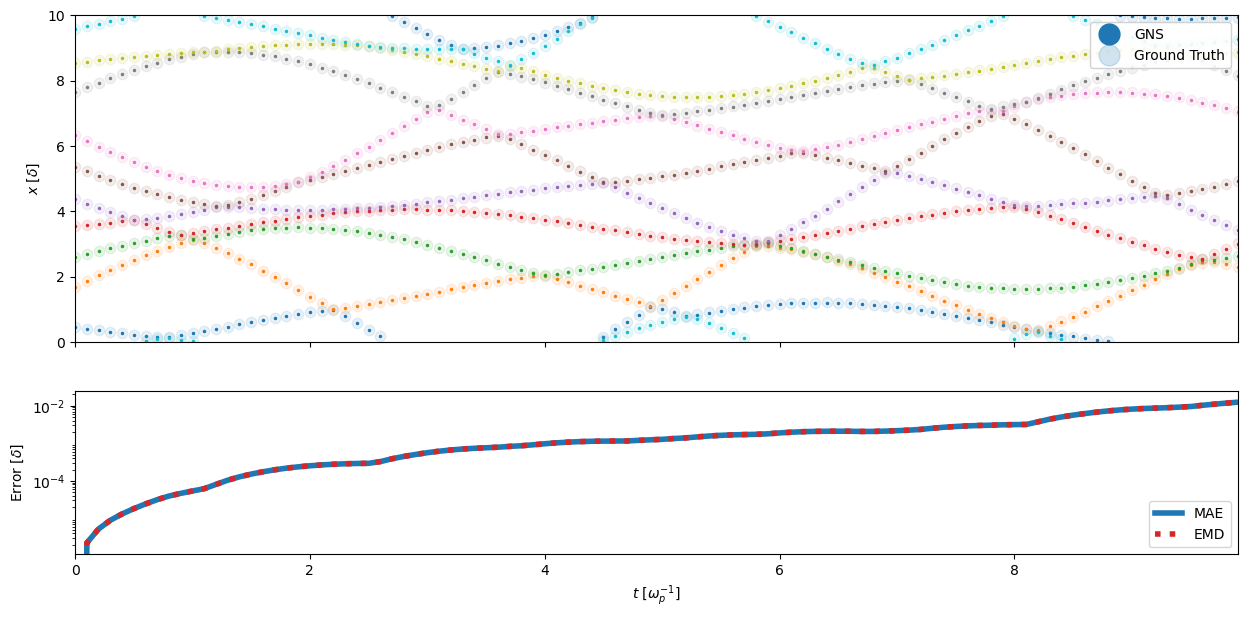

In [21]:
plot_trajectory_comparison(X_gns, 
                           X_sm[::dt_undersample][1:], 
                           boundary, sim.dt_train, normalize_dx_eq=True) 

## Where to go next?

For further examples on how to use the GNS to study plasma dynamis feel free to check the notebooks available in [notebooks/examples](../examples).